<a href="https://colab.research.google.com/github/AdamNur422/ITCS-5156/blob/main/13_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers


### ITCS 5156
### Minwoo "Jake" Lee

<br/>
<font color="blue"><b>

NAME: Adam Nur 

</b> </font>

# Goal

The goal of this lab is to make you get familiar with Transformers. We will be using the IMDB Movie Review Dataset to implement the transformer architecture and achieve tasks related to sentimental analysis. Follow the TODO titles and comments to finish the activity!

# Agenda

* Reading the Data
* Data Preprocessing
* Data Splitting
* Tokenization
* Dataloaders
* Transformer Initialization
* Training
* Testing
* Evaluation
* Inference

# Tables of TODO's


1. [TODO1 (5 points)](#TODO1)
2. [TODO2 (10 points)](#TODO2)
3. [TODO3 (5 points)](#TODO3)
4. [TODO4 (5 points)](#TODO4)  
5. [TODO5 (10 points)](#TODO5)
6. [TODO6 (15 points)](#TODO6)
7. [TODO7 (5 points)](#TODO7)
8. [TODO8 (15 points)](#TODO8)
9. [TODO9 (10 points)](#TODO9)
10. [TODO10 (15 points)](#TODO10)
11. [Feedback (5 points)](#Feedback)


Well, let us start the lab with importing the common libraries first.

In [3]:
import pandas as pd
import re
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import numpy as np
import time
import datetime

In [4]:
# Checking GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is being used")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

GPU is being used


# Sentimental Analysis

We will be considering IMDB Movie Reviews Dataset for performing machine learning tasks on Sentimental Analysis Data. This dataset consists of 50,000 movie reviews stored in the column `review` and each review is assignned a label as either positive or negative, stored in the column `sentiment`.

<br>

Sample Row:

**Review:**
`A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.`

**Sentiment:** Positive

<br>

**You can download the dataset from this Lab Submission page on Canvas. We suggest you to place the dataset in the same directory where this notebook is located.**

## Reading the data

### TODO 1 (5 points)

1. Load the IMDB Movie Reviews Dataset  using `read_csv` function. Store the dataframe in `df`.
2. Redefine the dataframe `df` to have only the first 15000 rows of the dataset.
3. Print the dataframe and the shape of the dataframe `df`.

In [8]:
# TODO 1
df = pd.read_csv('/content/IMDB Dataset.csv')
df = df.head(15000)
print(df)
print(df.shape)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
14995  Bobcat Goldthwait should be commended for atte...  negative
14996  And it's not because since her days on "Claris...  positive
14997  A traveling couple (Horton and Hamilton)stumbl...  negative
14998  This film is deeply disappointing. Not only th...  negative
14999  The revelation here is Lana Turner's dancing a...  positive

[15000 rows x 2 columns]
(15000, 2)


## Data preprocessing

Preprocessing the data is essential for effectively analyzing and modeling sentiment in the IMDb movie review dataset. If you look at the sample example review provided at the start, there are HTML tags `("<br />")` and special characters like apostrophes ("'") that need to be removed or handled appropriately. Additionally, the review contains punctuation and capitalization variations that should be standardized for consistency. Furthermore, stopwords (common words like "the", "is", "and") may need to be removed to focus on meaningful content. Tokenization is also necessary to break down the text into individual words or tokens for analysis. By preprocessing the data, we can ensure that the text is in a clean and consistent format, which helps improve the accuracy and effectiveness of sentiment analysis models trained on this dataset. Follow the below steps to preprocess the data.


### TODO 2 (10 points)

1. Encode the sentiments positive and negative to 1 and 0 respectively. Store it in `df.sentiment`.
2. Complete the process_text function below to remove any specific characters and patterns in each review. Use the method `re.sub` to
   - Replace characters like `[,\.!?:()"]` with an empty string ('').
   - Remove HTML tags by replacing any content between < and > with a space (' ').
   - Replace URLs starting with `http` followed by any non-whitespace characters with a space (' ').
   - Replace any characters that are not alphanumeric or whitespace with a space.
   - Replace multiple consecutive whitespace characters with a single space.
   - Convert the processed text to lowercase using the `lower()` method.
   - Use the `strip()` method to remove leading and trailing whitespace.
   - Return the processed text.
      

In [9]:
# TODO 2.1
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def process_text(x):
    # TODO 2.2
    x = re.sub(r'[,\.!?:()"]', '', x)
    x = re.sub(r'<[^>]+>', ' ', x)
    x = re.sub(r'http\S+', ' ', x)
    x = re.sub(r'[^a-zA-Z0-9\s]', ' ', x)
    x = re.sub(r'\s+', ' ', x)
    x = x.lower().strip()
    return x

df['review'] = df['review'].apply(lambda x: process_text(x))
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


## Data Splitting

### TODO 3 (5 points)

1. Using `train_test_split`, split the dataframe to `train` and `test` data with a `test_size` of 0.2.
2. Repeat the same with `train` by splitting into `train` and `validation` with `test_size` set to 0.1.

In [10]:
# TODO 3.1 - 3.2
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, validation = train_test_split(train, test_size=0.1, random_state=42)

In [11]:
train_sentences = train.review.values
train_labels = train.sentiment.values
test_sentences = test.review.values
test_labels = test.sentiment.values
validation_sentences = validation.review.values
validation_labels = validation.sentiment.values

## Transformers

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1-727x1024.png" alt="Transformer Model Architecture" height="500"/>


The transformer architecture adopts an encoder-decoder framework. The encoder, positioned on the left, converts input sequences into continuous representations. Meanwhile, the decoder, situated on the right, utilizes both the encoder output and its own previous output to generate an output sequence. This setup enables transformers to handle sequence-to-sequence tasks like translation. Removing the encoder component from the transformer yields insights into contextual information, leading to intriguing applications.

## Bidirectional Encoder Representation from Transformer (BERT)

<img src="https://huggingface.co/blog/assets/52_bert_101/BERT-size-and-architecture.png" alt="BERT Model Architecture" height="300"/>

BERT (Bidirectional Encoder Representation from Transformer) harnesses attention mechanisms for a nuanced understanding of language context. Comprising numerous encoder blocks, BERT processes input text by tokenizing it into tokens, akin to the transformer model. Each token undergoes transformation into a vector, forming the output of BERT.

## Tokenization

### TODO 4 (5 points)

1. Initialize BERT Tokenizer by using `BertTokenizer.from_pretrained()` with the model name `bert-base-uncased` and set `do_lower_case=True`.
2. Pass `train_sentences` and `train_labels` to `generate_data` function. Store the resulting output from function in `train_input_ids, train_attention_masks, train_labels`.
3. Repeat the same for test and validation sentences and labels. Store them in:
  - Test: `test_input_ids, test_attention_masks, test_labels`
  - Validation: `validation_input_ids, validation_attention_masks, validation_labels`.

In [12]:
# TODO 4.1
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The above piece of code initializes a BERT tokenizer from the Hugging Face Transformers library pretrained on the 'bert-base-uncased' model. By setting `do_lower_case=True`, the tokenizer converts all input text to lowercase, consistent with the model's training. This tokenizer enables the conversion of raw text input into numerical tokens compatible with BERT-based models, facilitating various downstream NLP tasks.

In [13]:
def generate_data(data, labels):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_dict = tokenizer.encode_plus(
                          sent,
                          add_special_tokens=True,
                          max_length=64,
                          padding='max_length',
                          return_attention_mask=True,
                          truncation=True,
                          return_tensors='pt')

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

The function `generate_data` above takes a list of text data (`data`) and corresponding labels (`labels`) as input. It iterates over each text sample in the data, encoding it using the BERT tokenizer (`tokenizer.encode_plus`). The encoded text is processed to include special tokens, ensure a maximum sequence length of 64 tokens, and pad shorter sequences to match the maximum length. Additionally, attention masks are generated to differentiate between actual tokens and padded tokens. The function then returns the encoded input IDs, attention masks, and labels as PyTorch tensors, ready to be used for training or evaluation in a BERT-based model.

In [14]:
# TODO 4.2 - 4.3
train_input_ids, train_attention_masks, train_labels = generate_data(train_sentences, train_labels)
test_input_ids, test_attention_masks, test_labels = generate_data(test_sentences, test_labels)
validation_input_ids, validation_attention_masks, validation_labels = generate_data(validation_sentences, validation_labels)

## Dataloaders

### TODO 5 (10 points)

1. Set `batch_size` to 32.
2. Create tensor datasets for train, test, and validation datasets using `TensorDataset` function. Pass the corresponding `input_ids, attention_masks, labels` to the function and store them in `train_dataset`, `test_dataset`, and `validation_dataset` for train, test, and validation data respectively.
3. Use `DataLoader` and pass the train/validation/test datasets (`train_dataset, validation_dataset, test_dataset`) as arguments.

   - Set the `sampler` parameter to `RandomSampler(train_dataset)` for the training data loader, and `SequentialSampler(validation_dataset)` and `SequentialSampler(test_dataset)` for the validation and test data loaders respectively.
   - Specify the batch size using the `batch_size` parameter.

In [15]:
# TODO 5.1 - 5.3
batch_size = 32

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
validation_dataset = TensorDataset(validation_input_ids, validation_attention_masks, validation_labels)

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    validation_dataset,
    sampler=SequentialSampler(validation_dataset),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

## How to use BERT for our downstream tasks?

<img src="https://webpages.charlotte.edu/mlee173/teach/ml/images/class/BERT_classify.png" alt="Applying BERT on our data" height="300" />


This flowchart depicts the application of BERT for sentiment analysis of movie reviews from the IMDB dataset. BERT, a pre-trained deep learning model, excels at understanding contextual meaning in text. The process leverages BERT's knowledge to build a sentiment analysis model:

1. **Data Acquisition:** The process begins with the IMDB movie review dataset, a collection of labeled reviews categorized as positive or negative.

2. **Pre-trained BERT Model:** A pre-trained BERT model, trained on massive amounts of text data, serves as the foundation. This model possesses the ability to capture complex relationships between words and sentences, providing a strong base for sentiment analysis.

3. **New Head Layer:**  A new head layer specifically designed for sentiment classification is added on top of the pre-trained BERT model. This head layer acts as the final decision layer, taking the contextual information extracted by BERT and translating it into sentiment categories (positive or negative).

4. **Model Fine-Tuning:** The entire system, including the pre-trained BERT model and the newly added sentiment classification head, undergoes fine-tuning using the IMDB dataset. This fine-tuning process adjusts the weights within the model to optimize its performance for the specific task of sentiment analysis in movie reviews.

5. **Sentiment Prediction:** Once fine-tuned, the model can be used for sentiment prediction on new, unseen movie reviews. By processing the review text through the BERT layers and the sentiment classification head, the model predicts the overall sentiment of the review.


## Model Initialization

For this lab, we will be using the `BertForSequenceClassification`, a pre-trained BERT model fine-tuned for sequence classification tasks. It consists of the BERT architecture followed by a classification layer. The BERT model encodes input sequences into contextualized representations, capturing intricate semantic and syntactic information. The classification layer then predicts the sequence's label based on these representations. During fine-tuning, the classification layer is trained on task-specific labeled data while the BERT parameters are fine-tuned. You can refer to this [link](https://huggingface.co/docs/transformers/en/model_doc/bert#transformers.BertForSequenceClassification) to learn more about the same.

### TODO 6 (15 points)

1. Initialize BERT for Sequence Classification Model by using `BertForSequenceClassification.from_pretrained()` method from the Hugging Face Transformers library. Store it in `model`.

   - Pass the model name `bert-base-uncased` as the first argument.
   - Specify the number of labels using the `num_labels` parameter (in this case, 2 for binary classification).
2. Use the `to()` method of the `model` to move it to the specified device (`device`).
3. Write a brief explanation on the structure of the model.

In [16]:
# TODO 6.1 - 6.2
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
)

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

`TODO 6.3:` Explain the structure of the model in brief.

`ANSWER:` The first layer is a Embeddings Layer that converts input text tokens into vectors for the model to understand the context better. After that is 12 encoder layers that process the embeddings so the model foxuses on different part of a ssentence to understand contect better. After that is an outer layer  to make a choice if the movie is good or bad. Finally the output from the last encoder layer is pooled and passed through a classifier to predicts the label of the sequence.

## Training

### TODO 7 (5 points)

1. Set the number of epochs to train the model to 4. Store it in `epochs`.

2. **Initialize Optimizer**:
   - Use `AdamW` optimizer from the Hugging Face Transformers library.
   - Pass the model parameters (`model.parameters()`) to optimize.
   - Set the learning rate (`lr`) to 2e-5 and epsilon (`eps`) to 1e-8.
   - Assign the initialized optimizer to the variable `optimizer`.


3. **Calculate Total Steps**:
   - Compute the total number of training steps.
   - Multiply the number of batches in the training data loader by the number of epochs.
   - Store it in `total_steps`.

4. **Initialize Scheduler**:
   - Use `get_linear_schedule_with_warmup` method from the Hugging Face Transformers library.
   - Pass the initialized optimizer, setting `num_warmup_steps=0` and `num_training_steps=total_steps`.
   - Assign the initialized scheduler to the variable `scheduler`.

In [17]:
# TODO 7.1 - 7.4
epochs = 4
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# The code in this cell helps to show the time taken for training purposes.

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### TODO 8 (15 points)

In this stage, we shall begin the training process. Follow the below instructions.

1. Train the model using `train()` method.

2. Use `zero_grad()` to clear the gradients of the `model` parameters.

2. Call the model with the input arguments (`b_input_ids`, `token_type_ids=None`, `attention_mask=b_input_mask`, `labels=b_labels`) to perform a forward pass. Set `return_dict=True` to return a dictionary of outputs. Store in a variable named `result`.

3. Access the loss and logits from the returned result using `.loss` and `.logits` respectively. Store the loss in a variable named `loss` and the logits in a variable named `logits`.

4. Perform a backward pass on `loss` to calculate gradients using `backward()`.

5. Update the model parameters using the `optimizer` with `step()`.

6. Update the learning rate `scheduler` using the method `step()`.

Note: This cell takes some time to run.

In [19]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

# For every epoch:
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0

    # TODO 8.1
    model.train()

    # For every batch:
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('Training Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # TODO 8.2
        model.zero_grad()

        # TODO 8.3
        result = model(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_input_mask,
                              labels=b_labels,
                              return_dict=True)

        # TODO 8.4
        loss = result.loss
        logits = result.logits

        # Update Total Training Loss
        total_train_loss += loss.item()

        # TODO 8.5
        loss.backward()

        # Clip the gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # TODO 8.6
        optimizer.step()

        # TODO 8.7
        scheduler.step()

    # Calculation of average training loss and time taken for training
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    t0 = time.time()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Storing all the training stats
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training Batch    40 of   338. Elapsed: 0:00:14.
Training Batch    80 of   338. Elapsed: 0:00:27.
Training Batch   120 of   338. Elapsed: 0:00:40.
Training Batch   160 of   338. Elapsed: 0:00:53.
Training Batch   200 of   338. Elapsed: 0:01:07.
Training Batch   240 of   338. Elapsed: 0:01:20.
Training Batch   280 of   338. Elapsed: 0:01:33.
Training Batch   320 of   338. Elapsed: 0:01:47.

Average training loss: 0.45
Training epoch took: 0:01:53

======== Epoch 2 / 4 ========
Training Batch    40 of   338. Elapsed: 0:00:14.
Training Batch    80 of   338. Elapsed: 0:00:27.
Training Batch   120 of   338. Elapsed: 0:00:41.
Training Batch   160 of   338. Elapsed: 0:00:55.
Training Batch   200 of   338. Elapsed: 0:01:09.
Training Batch   240 of   338. Elapsed: 0:01:22.
Training Batch   280 of   338. Elapsed: 0:01:36.
Training Batch   320 of   338. Elapsed: 0:01:50.

Average training loss: 0.28
Training epoch took: 0:01:56

======== Epoch 3 / 4 ========
Trainin

## Testing and Evaluation

The below cell evaluates the trained BERT model's performance on the test dataset. First, it initializes tracking variables to store predictions and true labels. Then, it iterates over batches of data from the test data loader. For each batch, it moves the data to the GPU (if available) and performs a forward pass through the model to obtain logits, which represent the model's raw predictions. The logits and corresponding true labels are then transferred to the CPU and stored. After iterating through all batches, the logits are converted into predicted labels by taking the argmax along the second axis (axis=1) to select the label with the highest probability. These predicted labels are aggregated into a single list and stored in `prediction_scores`. We will be using these prediction scores to compute the values of various metrics.

In [20]:
model.eval()

# Tracking variables
predictions , true_labels = [], []

for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

### TODO 9 (10 points)

1. Print the classification report using `test_labels` and `prediction_scores`.
2. Similarly, print the confusion matrix.
3. Comment on the performance metrics.

In [25]:
true_labels_flattened = [item for sublist in true_labels for item in sublist]

In [26]:
# TODO 9.1
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels_flattened, prediction_scores))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1560
           1       0.80      0.85      0.83      1440

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



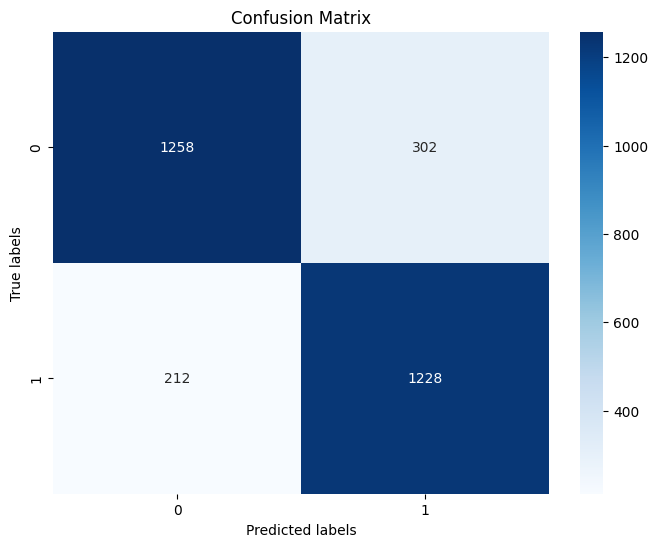

In [32]:
# TODO 9.2
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels_flattened, prediction_scores)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

`TODO 9.3:` Comment on the performance of the model.

`ANSWER:` The model has 83% accuracy which means that it does a fairly good job of predicting whether movie reviews are positive or negative, its also as equally good at catching the positive and negative reviews because of the recall. It also 212 cases of false negatives and 302 false positives

## Inference

Now that we are done with training and testing, lets experiment our trained model on reviews of our own.

### TODO 10 (15 points)

Follow the below instructions to complete the `predict_statement` function that helps us to run an inference based on our trained model.

1. **Process the Review Text**:
   - Use the `process_text` function to preprocess the review text. Store the preprocessed text in `processed_text`.

2. **Tokenize the Text**:
   - Use the `tokenizer.encode_plus()` method to tokenize the `processed_text`.
   - Set `add_special_tokens=True` to add special tokens for BERT model.
   - Set `max_length=64` to ensure the text is truncated or padded to a maximum length of 64 tokens.
   - Set `padding='max_length'` to pad the sequences to the maximum length.
   - Set `truncation=True` to truncate sequences longer than `max_length`.
   - Return the tokenized inputs as PyTorch tensors.
   - Store it in `inputs`.

3. **Ensure Evaluation Mode**:
   - Set the model to evaluation mode using `model.eval()`.

4. **Make Prediction**:
   - Pass `input_ids` and `attention_mask` to the `model` and store it in `outputs`. The `input_ids` represent the tokenized input sequence, while the `attention_mask` indicates which tokens should be attended to and which should be ignored.

5. **Get Predicted Labels**:
   - Access the `logits` from `outputs` and store them in `logits`.
   - Use `torch.softmax()` to compute softmax probabilities from the `logits` along the specified dimension `(dim=1)`. Store it in `probabilities`.
   - Use `torch.argmax()` to get the index of the maximum probability as the predicted label. Use `.item()` to extract the predicted label as a Python scalar. Store it in `predicted_label`.

6. **Make Inference**:
   - Make inference on the trained model by passing the model, tokenizer, device, and a review-like sentence of your choice to the `predict_statement` fucntion. Explore various sentences of both positive and negative types.


**Note**:
1. Steps 1-5 are the instructions that need to be performed to complete the `predict_statement` function.
2. In Step-6, you have to create at least two review-like sentences on your own, one for positive, and the other for negative, and run the inference on them.

In [36]:
import torch

def predict_sentiment(review_text, model, tokenizer, device):

    # TODO 10.1: Process the review text
    processed_text = process_text(review_text)

    # TODO 10.2: Tokenize the text
    inputs = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Move the inputs to the appropriate device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # TODO 10.3: Ensure evaluation mode
    model.eval()


    with torch.no_grad():
        # TODO 10.4: Make the prediction
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)


    # TODO 10.5: Get the predicted label
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_label = torch.argmax(probabilities, dim=1).item()


    # Map predicted label to sentiment
    sentiment = 'positive' if predicted_label == 1 else 'negative'
    return sentiment

# TODO 10.6: Example usage
positive_review = "This movie was pretty good. I really liked the visuals."
negative_review = "I was really mid. I ahted the music in the background"

print(f"Predicted sentiment for review-1: {predict_sentiment(positive_review, model, tokenizer, device)}")
print(f"Predicted sentiment for review-2: {predict_sentiment(negative_review, model, tokenizer, device)}")

Predicted sentiment for review-1: positive
Predicted sentiment for review-2: negative



# Feedback (5 points)

Did you enjoy the lab?

Please take time to answer the following feedback qustions to help us further improve these labs! Your feedback is crucial to making these labs more useful!

* How do you rate the overall experience in this lab? (5 likert scale. i.e., 1 - poor ... 5 - amazing)  
Why do you think so? What was most/least useful?

`ANSWER:`5


* What did you find difficult about the lab? Were there any TODOs that were unclear? If so, what specfically did not make sense about it?`

`ANSWER:` N/A

* Which concepts, if any, within the lab do you feel could use more explanation?

`ANSWER:` N/A